## Imports

In this section, we'll import:
- `json` to parse the JSON documents
- `wordcloud` for the creation of a word cloud
- `matplotlib` to show the word cloud
- `lookup_json` (local) to allow the extraction of all lyrics from the tracks 

In [1]:
import os
import json
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

import lookup_json

## Read the text

In [2]:
with open(os.curdir + "/../data/backup-tracks.json", 'r') as f:
    obj = json.load(f)

In [4]:
text = " ".join(lookup_json.dump(obj, ["*", "lyrics", "*", "content"]))

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

KeyboardInterrupt: 

## Descriptive Statistics

In [3]:
def get_present_values(obj, path):
    missing = []
    
    values = list(lookup_json.dump(obj, path, missing))
    present_values = list(filter(lambda x: x is not missing, values))
    
    return (present_values, values)

def print_missing(obj, path, name):
    present_values, values = get_present_values(obj, path)
    print(f"Missing {name} (%): {100 - (100 * len(present_values) / len(values))}")
    

In [4]:
print_missing(obj, ["*", "publishedAt"], "publishedAt")
print_missing(obj, ["*", "album"], "album")
print_missing(obj, ["*", "album", "image"], "album.image")
print_missing(obj, ["*", "lyrics", "0", "title"], "lyrics.0.title")
print_missing(obj, ["*", "duration"], "duration")
print_missing(obj, ["*", "publishedAt"], "publishedAt")

df_durations = pd.DataFrame(get_present_values(obj, ["*", "duration"])[0], columns=["duration"])
df_durations.describe()

Missing publishedAt (%): 68.26664962290681
Missing album (%): 8.80097149431164
Missing album.image (%): 3.3335669399864543
Missing lyrics.0.title (%): 12.787080830031101
Missing duration (%): 20.657036942349478
Missing publishedAt (%): 68.26664962290681


,duration
count,3.724200e+04
mean,2.181480e+05
std,7.829228e+04
min,3.000000e+03
25%,1.780000e+05
50%,2.110000e+05
75%,2.480000e+05
max,3.922000e+06


In [6]:
wc_regex = re.compile(r"\b\S+\b")

def get_words(text):
    yield from map(lambda x: x.group(), wc_regex.finditer(text))

In [7]:

word_counts = []
section_counts = []

weird_songs = []
for index, lyrics in enumerate(lookup_json.dump(obj, ["*", "lyrics"])):
    sections = list(lookup_json.dump(lyrics, ["*", "content"]))
    
    text = "\n".join(sections)
    num_words = len(list(get_words(text)))
    if num_words == 0:
        weird_songs.append(lookup_json.dump(obj, [str(index), "lyrics"]).__next__())
    
    section_counts.append(len(sections))
    word_counts.append(num_words)
    
# print(weird_songs)
    
df_word_counts = pd.DataFrame(word_counts, columns=["word_count"])
print(df_word_counts.describe().style.to_latex())

df_section_counts = pd.DataFrame(section_counts, columns=["section_count"])
# df_section_counts.describe().style.to_latex()

\begin{tabular}{lr}
 & word_count \\
count & 46938.000000 \\
mean & 321.518812 \\
std & 189.154448 \\
min & 1.000000 \\
25% & 192.000000 \\
50% & 287.000000 \\
75% & 409.000000 \\
max & 5425.000000 \\
\end{tabular}



\begin{tabular}{llr}
\toprule
{} &             Genre &  Number of tracks \\
\midrule
0  &              rock &              9078 \\
1  &           hip-hop &              3947 \\
2  &               rap &              3480 \\
3  &  female vocalists &              3401 \\
4  &  alternative rock &              2883 \\
5  &           hip hop &              2664 \\
6  &              soul &              1989 \\
7  &        indie rock &              1867 \\
8  &         indie pop &              1187 \\
9  &         hard rock &              1106 \\
10 &              trap &              1043 \\
11 &             k-pop &               960 \\
12 &          new wave &               858 \\
13 &              funk &               680 \\
14 &         punk rock &               655 \\
15 &       heavy metal &               596 \\
16 &             house &               577 \\
17 &             disco &               569 \\
18 &         dream pop &               565 \\
19 &               emo &               54

/tmp/ipykernel_137534/222719009.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_tag_counts.to_latex())


<Axes: ylabel='Genre'>

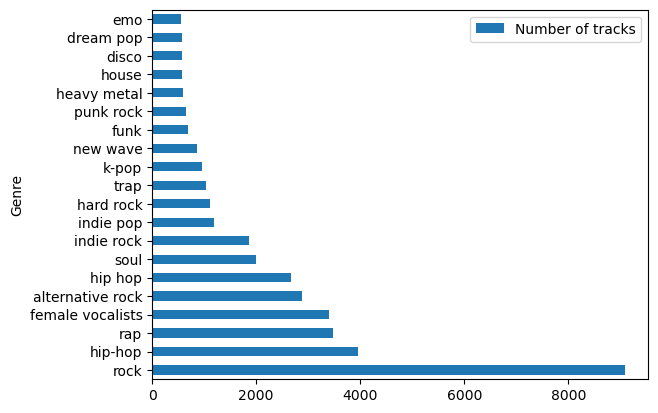

In [11]:
genre_counts = {}
for genre in lookup_json.dump(obj, ["*", "genres", "*"]):
    if genre in genre_counts:
        genre_counts[genre] += 1
    else:
        genre_counts[genre] = 1
 
       
genre_items = list(sorted(genre_counts.items(), key=lambda x: x[1], reverse=True))[0:20]

df_tag_counts = pd.DataFrame(genre_items, columns=["Genre", "Number of tracks"])
df_tag_counts.describe()

print(df_tag_counts.to_latex())

df_tag_counts.plot.barh(x="Genre", y="Number of tracks")
# df_tag_counts.head(20).plot.barh(x="Genre", y="Number of tracks")


<Axes: ylabel='Year'>

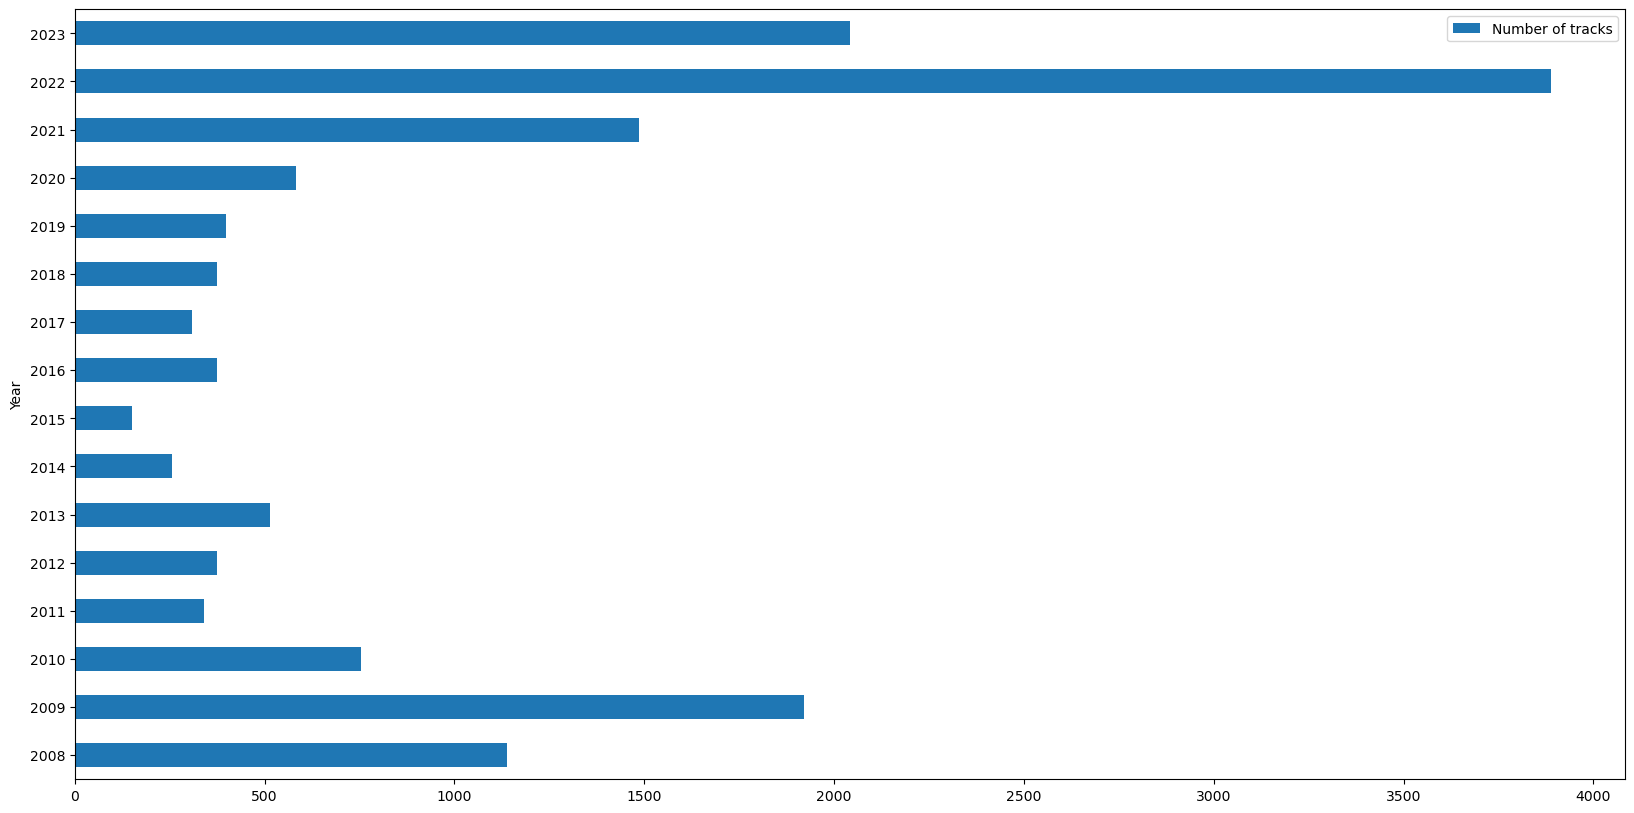

In [10]:
year_counts = {}

dates = lookup_json.dump(obj, ["*", "publishedAt"])
for date in dates:
    year = date.split(",")[0].split(" ")[-1]
    if year in year_counts:
        year_counts[year] += 1
    else:
        year_counts[year] = 1
        
year_items = list(sorted(year_counts.items(), key=lambda x: x[0], reverse=False))
df_year_counts = pd.DataFrame(year_items, columns=["Year", "Number of tracks"])
df_year_counts.describe()

df_year_counts.plot.barh(x="Year", y="Number of tracks", figsize=(20, 10))